# Determining the bottle neck

During the execution of the program, it was clear that at some point there is a bottle neck. However, I was not able to identify from where the bottle neck comes from.

**First bottleneck**: We have identified that the last bottleneck was the UTXO map. I have implemented a lock-free variant; the bottle neck has disappeared.

**Second bottleneck**: The server can be run with 100% CPU on the local host now, but only with 50% CPU on AWS.

I have the feeling that the bottle neck is in the go net/rpc library. There have been a few reports of bad performance of net/rpc, but nothing has been confirmed as of yet. The development has also been discontinued for net/rpc. Also, if I'm executing the server subroutine on different workers, it doesn't speed up well.

Also, the majority of blocking is caused by net/rpc. **It was unclear however whether the blocking really causes that the CPU is only 50%, locks spin**. I wanted to be sure that the net/rpc is really the bottle neck. If net/rpc blocks, shouldn't the CPU be 100%? What's more, I ran a benchmark which is sending rpc messages (without contention).

Two years ago, the developers of Go introduced this change to avoid starvation: I researched this, looked in the code of Golang and found this: https://golang.org/src/sync/mutex.go?s=2534:2556#L81. Go uses a atomic integer with CAS and a backoff lock. This could explain the 50% usage!

The next step is to port the entire communication to another library, for example gRPC or another TCP stream library, which has a better locking/response buffering mechanism.

I'm undecided between a simple TCP stream / scheduling library like this one https://github.com/panjf2000/gnet or a fully featured RPC library like gRPC https://grpc.io/

## AWS benchmark

This benchmark has been executed after the non-blocking UTXO hash map has been implemented.

For this server, I also made a benchmark which calculates how many tx are theoretically possible:

1 core: 1183 transactions per second

64 workers: 8022 transactions per second

64 core AWS server

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

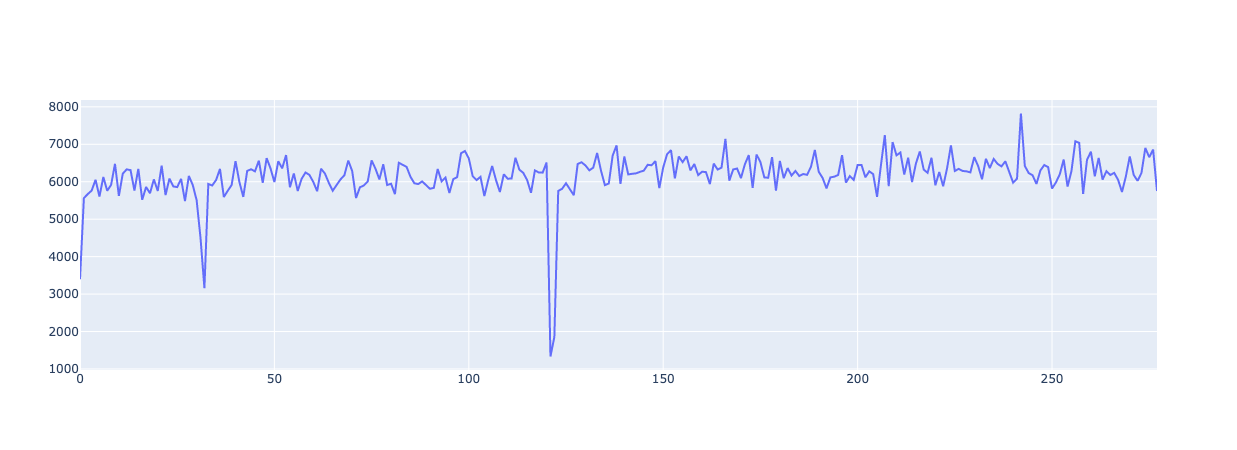

In [4]:
d1 = pd.read_csv("./bench/aws-april.csv")

fig = go.Figure([
    go.Scatter(y=d1['tx'], name="tx / s"),
])
fig.show()

The drops mean that the test has been restarted (by me)